In [855]:
import numpy as np
import qutip as qt

# Project 2: Numerical Quantum Mechanics

## What files should I submit?

* proj_2_module.py
* proj_2_EigenTest.ipynb
* proj_2_EigenTest.pdf
* proj_2_EigenAnalysis.ipynb
* proj_2_EigenAnalysis.pdf

The .pdf are converted from .ipynb.

## Write a Python module to compute eigenvalues and eigenvectors

The module should contain a function

    hermitian_eigensystem(H,tolerance)

allowing you to numerically determine the eigenvalues and eigenvectors of a hermitian matrix of any size.  

```H``` is a hermitian square matrix.

```tolerance``` is a small number, such that we consider $M$ is diagonal when:

$$
\text{off}[M] \leq \text{tolerance} * \text{norm}[M]
$$

($\text{off}[M]$ and $|M|$ defined in the lecture notes.)

The module can contain any other functions you wish that might help you divide and conquer the diagonalization task into relevant sub-parts.  The eigenvalues should be output in non-decreasing order, and the corresponding eigenvectors should be listed in corresponding order.  The module's name should be:

    proj_2_module.py


You may use ```numpy.linalg.eig``` or ```scipy.linalg.eig``` to check your method, but do not put them secretly in your module.

### hint
It is highly recommended that you split your functions into many parts.
You may design your own strategy. Below is one example.

* (A) jacobi_rotation
* (O) off
* (B) real_eigen calls (A) iteratively,  (B) also calls (O) to check if the matrix is consider as diagonal
* (C) complex_eigen calls (B)
* (D) hermitian_eigensystem calls (C), and makes the output ordered.

In [856]:
def generate_matrix(n, type='symmetric'):
    """
    Generate an n x n symmetric or Hermitian matrix.

    Args:
        n (int): The size of the matrix (number of rows and columns).
        type (str): The type of matrix to generate. Valid values are 'symmetric' or 'hermitian'.

    Returns:
        np.ndarray: An n x n symmetric or Hermitian matrix.
    """
    if type not in ['symmetric', 'hermitian']:
        raise ValueError("Type must be 'symmetric' or 'hermitian'")

    # Generate the base random matrix
    A = np.random.rand(n, n)

    if type == 'symmetric':
        # Make the matrix symmetric
        A = (A + A.T) / 2
    elif type == 'hermitian':
        # Generate an additional matrix for the imaginary parts
        B = np.random.rand(n, n)
        # Make the matrix Hermitian: A + iB (symmetric part) and then conjugate transpose for upper part
        A = A + 1j * B
        A = (A + A.conj().T) / 2
        # Make sure the diagonal is real
        np.fill_diagonal(A, np.real(A.diagonal()))

    return A

def is_symmetric(matrix):
    # Check if the matrix is square
    if matrix.shape[0] != matrix.shape[1]:
        return False
    
    # Check if the matrix is equal to its transpose
    return np.array_equal(matrix, matrix.T)

def find_largest_non_diagonal_index(matrix):
    min = np.finfo(float).min
    matrix = np.abs(matrix)
    index = (0, 0)
    for i in range(matrix[0].size):
        for j in range(matrix[0].size):
            if i == j:
                continue
            if matrix[i, j] > min:
                min = matrix[i, j]
                index = (i, j)
    return index

#difficulty: ★★★
def jacobi_rotation(A, j, k):
    #Args:
        # A (np.ndarray): n by n real symmetric matrix
        # j (int): column parameter.
        # k (int): row parameter.

    #Returns:
        # A (np.ndarray): n by n real symmetric matrix, where the A[j,k] and A[k,j] element is zero
        # J (np.ndarray): n by n orthogonal matrix, the jacobi_rotation matrix

    # getting the element for A
    a = A[j, j]
    b = A[k, k]
    c = A[j, k]

    theta = 0.5*(np.arctan2(2*c, a-b) )
    
    J = np.diag(np.full(A.shape[0], 1)).astype(float)
    J = np.identity(len(A))
    J[j, j] = np.cos(theta)
    J[j, k] = -np.sin(theta)
    J[k, j] = np.sin(theta)
    J[k, k] = np.cos(theta)
    A = J.transpose() @ A @ J
    
    return A, J

#difficulty: ★
def off(A, tol):
    # calculate the Frobenius norm of A and off(A)
    # to see if we want to stop the call
    A_off = A.copy()
    np.fill_diagonal(A_off, 0)
    off_norm = np.linalg.norm(A_off, 'fro')
    frob_norm = np.linalg.norm(A, 'fro')
    return (off_norm/frob_norm < tol)

#difficulty: ★★★
def real_eigen(A,tolerance):
    #Args:
        # A (np.ndarray): n by n real symmetric matrix
        # tolerance (double): the relative precision
    #Returns:
        # d (np.ndarray): n by 1 vector, d[i] is the i-th eigenvalue
        # R (np.ndarray): n by n orthogonal matrix, R[:,i] is the i-th eigenvector
        
    # call jacobi_rotation(A, j, k) iteratively
    # call off and norm to check if we can stop the iteration
    # off (you write it)
    # norm https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.norm.html

    J_arr = []

    # iterative process
    while (True):
        j, k = find_largest_non_diagonal_index(A)
        A, J = jacobi_rotation(A, j, k)
        J_arr.append(J)
        if off(A, tolerance):
            break

    # compute result
    R = np.diag(np.full(A.shape[0], 1))

    d = np.diagonal(A)
    for index in range(len(J_arr)):
        R = R @ J_arr[index]
    
    d = np.round(d, 7)
    R = np.round(R, 7)
    return d, R

In [857]:
def first_occurrences(array):
    # Dictionary to hold the first occurrence of each element
    first_occ_dict = {}
    # Iterate over the array and store the index of the first occurrence of each element
    for index, element in enumerate(array):
        if element not in first_occ_dict:
            first_occ_dict[element] = index
    
    # Return the results as a dictionary or in any format that suits your needs
    return first_occ_dict


def complex_to_real_matrix(H):
    real = np.real(H)
    imag = np.imag(H)
    out = np.block([[real, -imag], [imag, real]])

    return out

def real_to_complex_matrix(H):
    # Determine the size of the sub-matrices
    n = H.shape[0] // 2
    
    # Extract A and B from C
    A = H[:n, :n]  # Top left block
    B = H[n:, :n]  # Bottom left block
    
    return A+1j*B

def order_eigensystems(d, U, round = 7):
    d = np.round(d, round)
    U = np.round(U, round)

    indices = np.argsort(d.real)
    d = d[indices]
    U = U[:, indices]
    return d, U

#difficulty: ★★
def complex_eigen(H,tolerance):
    size = H[0].size
    if H.dtype != 'complex128':
        return real_eigen(H, tolerance)
    
    H = complex_to_real_matrix(H)
    d, U = real_eigen(H, tolerance)
    n = U[0].size
    top = U[:n//2, :]
    bot = U[n//2:, :]
    U = top + 1j*bot

    unique_eigenvalues = {}
    for i, e_val in enumerate(d):
        if e_val not in unique_eigenvalues:
            unique_eigenvalues[e_val] = i

    d = unique_eigenvalues.keys()
    indices = list(unique_eigenvalues.values())
    temp = U
    U = np.zeros((size, size), dtype='complex')
    for i in range(len(indices)):
        U[:,i] = temp[:,indices[i]]

    d_list = list(d)
    d = np.array(d_list)

    return d, U

#difficulty: ★
def hermitian_eigensystem(H,tolerance):
    
    # call complex_eigen(H,tolerance)
    # rearrange d and U, so that they are in the non-decreasing order of eigenvalues
    d, U = complex_eigen(H, tolerance)
    
    return order_eigensystems(d, U)

In [964]:
# def compare_complex_vectors(v1, v2, tolerance=1e-10):
#     print(v1)
#     print(v2)
#     # Compute potential lambda values
#     lambda_1 = v2[0] / v1[0]
#     lambda_2 = v2[1] / v1[1]

#     # Check if lambdas are approximately equal
#     are_same = np.isclose(lambda_1, lambda_2, atol = 1e-04, rtol = 1e-04)

#     return are_same

def compare_complex_vectors(v1, v2, tolerance=1e-3):
    # Check for zero denominators before division
    if np.isclose(v1[0], 0, atol=tolerance) and np.isclose(v2[0], 0, atol=tolerance):
        lambda_1 = 1  # Arbitrary non-zero to pass the check if both are zero
    elif not np.isclose(v1[0], 0, atol=tolerance):
        lambda_1 = v2[0] / v1[0]
    else:
        return False  # v1[0] is zero but v2[0] is not

    if np.isclose(v1[1], 0, atol=tolerance) and np.isclose(v2[1], 0, atol=tolerance):
        lambda_2 = 1  # Arbitrary non-zero to pass the check if both are zero
    elif not np.isclose(v1[1], 0, atol=tolerance):
        lambda_2 = v2[1] / v1[1]
    else:
        return False  # v1[1] is zero but v2[1] is not

    # Check if lambdas are approximately equal
    are_same = np.isclose(lambda_1, lambda_2, atol=1e-04, rtol=1e-04)

    return are_same

def compare_eigen_system(d_numpy, d_myfunc, U_numpy, U_myfunc):
    flag = True
    d_numpy, U_numpy = order_eigensystems(d_numpy, U_numpy)
    n = d_numpy.size
    for i in range(n):
        if not np.isclose(d_numpy[i], d_myfunc[i], atol = 1e-04, rtol = 1e-04):
            flag = False
    for i in range(n):
        if not compare_complex_vectors(U_numpy[:,i], U_myfunc[:,i]):
            flag = False

    return flag

In [859]:
rho = generate_matrix(4, type='hermitian')
d_numpy, R_numpy = np.linalg.eig(rho)
print('numpy: ')
print('eigenvalues:')
print(d_numpy)
print('eigenvecs:')
print(R_numpy)


print()
d_myfunc, R_myfunc = hermitian_eigensystem(rho, 1e-10)
print('my function: ')
print('eigenvalues:')
print(d_myfunc)
print('eigenvecs:')
print(R_myfunc)

numpy: 
eigenvalues:
[ 2.20320425+3.63955122e-18j -0.73590973+7.44080694e-18j
  0.37959913+1.94825167e-17j -0.08003237-3.75017688e-17j]
eigenvecs:
[[ 0.36344815+0.11146953j  0.66780941+0.j         -0.4021297 +0.14160872j
  -0.17882403-0.4424604j ]
 [ 0.57672274+0.j         -0.33058164+0.17364784j -0.33260889-0.3631878j
  -0.41975848+0.33048729j]
 [ 0.49146157+0.14952932j -0.17502618-0.46840607j -0.10565877+0.01628411j
   0.6889406 +0.j        ]
 [ 0.49479781-0.11896429j  0.28061465+0.2929331j   0.75118285+0.j
   0.05851034+0.09364356j]]

my function: 
eigenvalues:
[-0.7359097 -0.0800324  0.3795991  2.2032043]
eigenvecs:
[[-0.0129296-0.6676842j -0.4747627+0.0484732j  0.3727992-0.2068382j
   0.3696591+0.0887251j]
 [ 0.1800158+0.3271576j  0.2004564+0.4952133j  0.3886411+0.3024767j
   0.5756136-0.035751j ]
 [-0.4649295+0.1840623j  0.1919405-0.661663j   0.1014499-0.0337174j
   0.4997857+0.1187761j]
 [ 0.2874451-0.2862336j  0.106237 -0.0301044j -0.7406129+0.1255716j
   0.4864716-0.1494079j]]

In [860]:
compare_eigen_system(d_numpy, d_myfunc, R_numpy, R_myfunc)

True

In [861]:
def comphrehensive_test(n = 30):
    flag = True
    count_symmetric = 0
    for i in range(2, n+1):
        rho = generate_matrix(i, type='symmetric')
        d_numpy, R_numpy = np.linalg.eig(rho)
        d_myfunc, R_myfunc = hermitian_eigensystem(rho, 1e-15)
        if not compare_eigen_system(d_numpy, d_myfunc, R_numpy, R_myfunc):
            flag = False
            count_symmetric = count_symmetric+1

    count_hermitian = 0
    failed = []
    for i in range(2, n+1):
        rho = generate_matrix(i, type='hermitian')
        d_numpy, R_numpy = np.linalg.eig(rho)
        d_myfunc, R_myfunc = hermitian_eigensystem(rho, 1e-15)
        if not compare_eigen_system(d_numpy, d_myfunc, R_numpy, R_myfunc):
            flag = False
            count_hermitian = count_hermitian + 1
            failed.append(d_myfunc.size)
    print('Symmetric failed: ', count_symmetric)
    print('Hermitian failed: ', count_hermitian)
    print(failed)
    return flag

In [862]:
flag = True
for i in range(20):
    print('{}th comphrehensive_test'.format(i+1))
    if not comphrehensive_test():
        flag = False

assert flag == True
print("All test passed")

1th comphrehensive_test
Symmetric failed:  0
Hermitian failed:  0
[]
2th comphrehensive_test
Symmetric failed:  0
Hermitian failed:  0
[]
3th comphrehensive_test
Symmetric failed:  0
Hermitian failed:  0
[]
4th comphrehensive_test
Symmetric failed:  0
Hermitian failed:  0
[]
5th comphrehensive_test
Symmetric failed:  0
Hermitian failed:  0
[]
6th comphrehensive_test
Symmetric failed:  0
Hermitian failed:  0
[]
7th comphrehensive_test
Symmetric failed:  0
Hermitian failed:  0
[]
8th comphrehensive_test
Symmetric failed:  0
Hermitian failed:  0
[]
9th comphrehensive_test
Symmetric failed:  0
Hermitian failed:  0
[]
10th comphrehensive_test
Symmetric failed:  0
Hermitian failed:  0
[]
11th comphrehensive_test
Symmetric failed:  0
Hermitian failed:  0
[]
12th comphrehensive_test
Symmetric failed:  0
Hermitian failed:  0
[]
13th comphrehensive_test
Symmetric failed:  0
Hermitian failed:  0
[]
14th comphrehensive_test
Symmetric failed:  0
Hermitian failed:  0
[]
15th comphrehensive_test
Symm

## Write a Jupyter notebook containing code tests

The notebook is meant to validate the performance of your eigensystem module and should be named as:

    proj_2_EigenTest.ipynb


The notebook should contain:

Tests showing that for hermitian matrices of sizes up to 30-by-30 with known eigenvalues, the function `hermitian eigensystem` gives correct eigenvalues and eigenvectors.  To generate test cases, you'll need to think about how you can generate hermitian matrices with known eigenvalues.  Hint: what happens when you apply a similarity transformation by a unitary matrix to a diagonal matrix?  You may also find it useful to look into the function 'scipy.stats.unitary_group' which allows one to generate random unitary matrices.

## Write a Jupyter notebook analyzing the anharmonic oscillator

This notebook should use your eigensystem module to determine the first few eigenvalues and corresponding eigenvectors of the anharmonic oscillator hamiltonian.  The notebook should be named as:

    proj_2_EigenAnalysis.ipynb
        
1. Show that the operators $\hat x^2$ and $\hat x^4$ have the following matrix elements in the harmonic oscillator basis:
$$
    \begin{align}
    \langle n|\hat x^2|m\rangle 
    &=(n+1/2)\delta_{nm} + \tfrac{1}{2}\sqrt{(n+1)(n+2)}\,\delta_{n,m-2} + 
\tfrac{1}{2}\sqrt{(n-1)n\,}\,\delta_{n,m+2} \\
    \langle n|\hat x^4|m\rangle 
    &= \tfrac{1}{4}\!\left(6n^2 + 6n + 3\right)\!\delta_{nm}
+ \sqrt{(n+1)(n+2)}\left(n+\tfrac{3}{2}\right)\!\delta_{n,m-2}\;+ \nonumber\\
& + \sqrt{(n-1)n\,}\left(n-\tfrac{1}{2}\right)\!\delta_{n,m+2} +
\tfrac{1}{4}\sqrt{(n+1)(n+2)(n+3)(n+4)}\,\delta_{n,m-4}\;+ \nonumber\\
& + \tfrac{1}{4}\sqrt{(n-3)(n-2)(n-1)n\,}\,\delta_{n,m+4}.
\end{align}$$
1. Solve the anharmonic oscillator eigenvalue problem written in the harmonic oscillator basis for at least the first four energy levels. Note that the function `hermval` from NumPy offers an easy solution to compute the eigenfunctions $\psi_n(x)$ from the eigenvectors of the matrix representation of the hamiltonian. 
1. Plot the first four energy 
levels $E_n(\lambda)$ versus $\lambda$ over the range 
$0 \leq \lambda \leq 1$. Plot also the spacings between the 
levels $\Delta E(\lambda) = E_{n+1}(\lambda) - E_n(\lambda)$. Make sure to use a basis 
size $N$ sufficiently larger than the desired number of lowest eigenvalues to ensure convergence of the eigensystem algorithm.
1. Check the convergence of the method with respect to the basis size $N$ by plotting one 
of the lowest (or more) energy eigenvalues $E_n(N)$ for $\lambda = 1$ versus the basis size $N$. 
Alternatively, to demonstrate the convergence more clearly, you can also plot the differences between 
two consecutive estimates $\epsilon_n = E_n(N) - E_n(N\!+\!2)$ versus $N$.
1. Plot and compare the first four eigenfunctions $\psi_n(x)$ for the harmonic oscillator with $\lambda=0$ to 
the eigenfunctions for the anharmonic oscillator with $\lambda=1$.

## Matrix Elements of $\hat{x}^2$ for a Quantum Harmonic Oscillator

The position operator $\hat{x}$ in terms of the annihilation operator $\hat{a}$ and creation operator $\hat{a}^\dagger$ is defined as:

$$
\hat{x} = \sqrt{\frac{1}{2}} (\hat{a} + \hat{a}^\dagger)
$$

Expanding the square of the position operator, we have:

$$
\hat{x}^2 = \left(\sqrt{\frac{1}{2}} (\hat{a} + \hat{a}^\dagger)\right)^2 = \frac{1}{2} (\hat{a}^2 + \hat{a}\hat{a}^\dagger + \hat{a}^\dagger\hat{a} + (\hat{a}^\dagger)^2)
$$

Using the commutation relation $[\hat{a}, \hat{a}^\dagger] = 1$, which implies $\hat{a}^\dagger\hat{a} = \hat{a}\hat{a}^\dagger - 1$, we can simplify:

$$
\hat{x}^2 = \frac{1}{2} (\hat{a}^2 + 2\hat{a}\hat{a}^\dagger - 1 + (\hat{a}^\dagger)^2)
$$

When we apply $\hat{x}^2 |n\rangle$, we see that 

$$
\hat{x}^2 |n\rangle = \frac{1}{2} \left(\sqrt{n(n-1)} |n-2\rangle + 2(n+1) |n\rangle + \sqrt{(n+1)(n+2)} |n+2\rangle\right)
$$


This implies that only $|n\rangle$ can only interact with $|n+2\rangle$, $|n-2\rangle$ and $|n\rangle$. All the other elements will yield 0 due to the orthogonality nature of the fock states. In addition, since $\hat{x}^2$ is hermitian and real (commutation relation), we can further explore the symmetry of the matrix element. Therefore, We can reduce the program to calculate the following element:

$$
\langle n|\hat{x}^2|n \rangle = \frac{1}{2} (2n + 1) = n + \frac{1}{2}
$$
$$
\langle n|\hat{x}^2|n-2 \rangle = \langle n-2|\hat{x}^2|n \rangle = \frac{1}{2} \sqrt{n(n-1)}
$$
$$
\langle n|\hat{x}^2|n+2 \rangle = \langle n+2|\hat{x}^2|n \rangle = \frac{1}{2} \sqrt{(n+1)(n+2)}
$$

Therefore, the matrix elements are:

$$
\langle n|\hat{x}^2|m\rangle = (n+\frac{1}{2})\delta_{nm} + \frac{1}{2}\sqrt{(n+1)(n+2)}\,\delta_{n,m-2} + \frac{1}{2}\sqrt{(n-1)n}\,\delta_{n,m+2}
$$


## Matrix Elements of $\hat{x}^4$ for a Quantum Harmonic Oscillator

The position operator $\hat{x}$ in terms of the annihilation operator $\hat{a}$ and creation operator $\hat{a}^\dagger$ is defined as:

$$
\hat{x} = \sqrt{\frac{1}{2}} (\hat{a} + \hat{a}^\dagger)
$$

Expanding the fourth power of the position operator, we have:

$$
\hat{x}^4 = \left( \sqrt{\frac{1}{2}} (\hat{a} + \hat{a}^\dagger) \right)^4 = \frac{1}{4} (\hat{a} + \hat{a}^\dagger)^4
$$

Using the binomial expansion and commutation relation $[\hat{a}, \hat{a}^\dagger] = 1$, we simplify the expansion to:

$$
\hat{x}^4 = \frac{1}{4} (\hat{a}^4 + 4 \hat{a}^3 \hat{a}^\dagger + 6 \hat{a}^2 (\hat{a}^\dagger)^2 + 4 \hat{a} (\hat{a}^\dagger)^3 + (\hat{a}^\dagger)^4)
$$

Applying this operator to the quantum state $|n\rangle$, we find:

$$
\hat{x}^4 |n\rangle = \frac{1}{4} \left( 
\sqrt{n(n-1)(n-2)(n-3)} |n-4\rangle + 
4\sqrt{n(n-1)(n-2)} (n-1) |n-2\rangle \right.
$$
$$
\left. + 6\sqrt{n(n-1)} n (n+1) |n\rangle + 
4\sqrt{(n+1)(n+2)} (n+3) |n+2\rangle + 
\sqrt{(n+1)(n+2)(n+3)(n+4)} |n+4\rangle 
\right)
$$

### Matrix Elements

The individual matrix elements are then:

$$
\langle n|\hat{x}^4|n \rangle = \frac{1}{4} \left( 6n^2 + 6n + 3 \right)
$$
$$
\langle n|\hat{x}^4|n-2 \rangle = \langle n-2|\hat{x}^4|n \rangle = \sqrt{(n+1)(n+2)} \left(n + \frac{3}{2}\right)
$$
$$
\langle n|\hat{x}^4|n+2 \rangle = \langle n+2|\hat{x}^4|n \rangle = \sqrt{(n-1)n} \left(n - \frac{1}{2}\right)
$$
$$
\langle n|\hat{x}^4|n-4 \rangle = \langle n-4|\hat{x}^4|n \rangle = \frac{1}{4} \sqrt{(n+1)(n+2)(n+3)(n+4)}
$$
$$
\langle n|\hat{x}^4|n+4 \rangle = \langle n+4|\hat{x}^4|n \rangle = \frac{1}{4} \sqrt{(n-3)(n-2)(n-1)n}
$$

These matrix elements define how $\hat{x}^4$ connects states within the Fock space, highlighting transitions not only to immediately adjacent states but also to states that are two and four quantum levels apart.


## Write a Jupyter notebook analyzing the anharmonic oscillator

This notebook should use your eigensystem module to determine the first few eigenvalues and corresponding eigenvectors of the anharmonic oscillator hamiltonian.  The notebook should be named as:

    proj_2_EigenAnalysis.ipynb
        
1. Show that the operators $\hat x^2$ and $\hat x^4$ have the following matrix elements in the harmonic oscillator basis:
$$
    \begin{align}
    \langle n|\hat x^2|m\rangle 
    &=(n+1/2)\delta_{nm} + \tfrac{1}{2}\sqrt{(n+1)(n+2)}\,\delta_{n,m-2} + 
\tfrac{1}{2}\sqrt{(n-1)n\,}\,\delta_{n,m+2} \\
    \langle n|\hat x^4|m\rangle 
    &= \tfrac{1}{4}\!\left(6n^2 + 6n + 3\right)\!\delta_{nm}
+ \sqrt{(n+1)(n+2)}\left(n+\tfrac{3}{2}\right)\!\delta_{n,m-2}\;+ \nonumber\\
& + \sqrt{(n-1)n\,}\left(n-\tfrac{1}{2}\right)\!\delta_{n,m+2} +
\tfrac{1}{4}\sqrt{(n+1)(n+2)(n+3)(n+4)}\,\delta_{n,m-4}\;+ \nonumber\\
& + \tfrac{1}{4}\sqrt{(n-3)(n-2)(n-1)n\,}\,\delta_{n,m+4}.
\end{align}$$
1. Solve the anharmonic oscillator eigenvalue problem written in the harmonic oscillator basis for at least the first four energy levels. Note that the function `hermval` from NumPy offers an easy solution to compute the eigenfunctions $\psi_n(x)$ from the eigenvectors of the matrix representation of the hamiltonian. 
1. Plot the first four energy 
levels $E_n(\lambda)$ versus $\lambda$ over the range 
$0 \leq \lambda \leq 1$. Plot also the spacings between the 
levels $\Delta E(\lambda) = E_{n+1}(\lambda) - E_n(\lambda)$. Make sure to use a basis 
size $N$ sufficiently larger than the desired number of lowest eigenvalues to ensure convergence of the eigensystem algorithm.
1. Check the convergence of the method with respect to the basis size $N$ by plotting one 
of the lowest (or more) energy eigenvalues $E_n(N)$ for $\lambda = 1$ versus the basis size $N$. 
Alternatively, to demonstrate the convergence more clearly, you can also plot the differences between 
two consecutive estimates $\epsilon_n = E_n(N) - E_n(N\!+\!2)$ versus $N$.
1. Plot and compare the first four eigenfunctions $\psi_n(x)$ for the harmonic oscillator with $\lambda=0$ to 
the eigenfunctions for the anharmonic oscillator with $\lambda=1$.

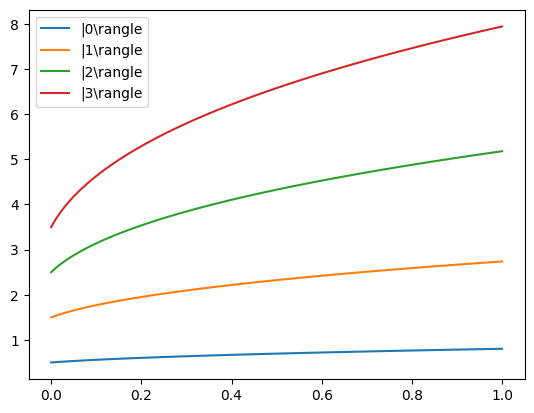

In [1029]:
# Parameters
omega = 1.0  
h_bar = 1
N = 30    
lamb = np.linspace(0,1, 100)
m = 1

# Operators
a = qt.destroy(N)        
a_dag = a.dag()          

# Position operator x
x = (a + a_dag) * (h_bar / (2 * m * omega))**0.5

# x^4 operator
x4 = x**4

# Hamiltonian
store = []

for i in range(lamb.size):
    H = omega * h_bar * (a_dag * a + 0.5)
    H_aharmonic = H + lamb[i]*x4
    H_aharmonic_np = H_aharmonic.full()

    d, U = hermitian_eigensystem(H_aharmonic_np, 1e-8)
    d_qutip, U_qutip = H_aharmonic.eigenstates()
    U_list = [U.full() for U in U_qutip]
    U_qutip = np.hstack(U_list)
    
    store.append(d[:4])

store = np.array(store)

for i in range(4):
    plt.plot(np.array(lamb), store[:,i], label = r'|{}\rangle'.format(i))

plt.legend()

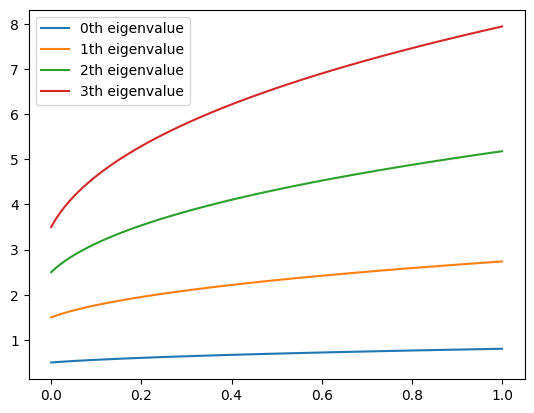

In [1030]:
for i in range(4):
    plt.plot(np.array(lamb), store[:,i], label = '{}th eigenvalue'.format(i))

plt.legend()

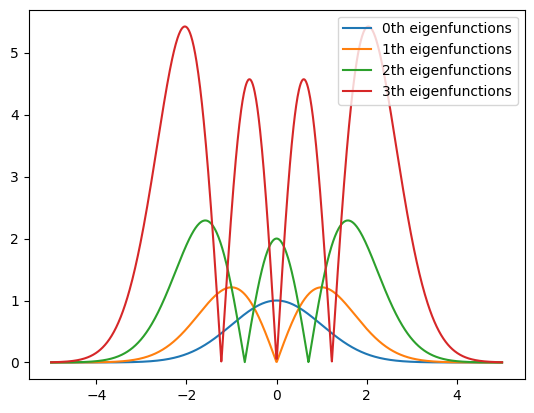

In [1036]:
H = omega * h_bar * (a_dag * a + 0.5)
d_qutip, U_qutip = H.eigenstates()
U_list = [U.full() for U in U_qutip]
U_qutip = np.hstack(U_list)
x = np.linspace(-5, 5, 1000)
for i in range(4):
    y = np.polynomial.hermite.hermval(x, U_qutip[:,i]) * np.exp(-x**2/2)
    plt.plot(x, np.abs(y), label = '{}th eigenfunctions'.format(i))

plt.legend()